**First we will import al the libraries that we will need**

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

**Here we are defining the fuctions that we are going to need for the pre-process**

In [9]:
def encode(dataframe, column):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    values = np.array(dataframe[column])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    list_onehot = []
    for i in range(onehot_encoded.shape[1]):
        list_onehot.append(column+str(i))

    df1 = pd.DataFrame(onehot_encoded, columns = list_onehot)

    dataframe [list_onehot[:-1]] = df1 [list_onehot[:-1]]

    return dataframe

def print_results():
    mae1 = history.history['mae']
    val_mae1 = history.history['val_mae']
    loss1 = history.history['loss']
    val_loss1 = history.history['val_loss']

    epochs1 = range(len(mae1))

    plt.figure(figsize=(16, 4))

    plt.plot(epochs1, mae1, 'b', label='Training mae')
    plt.plot(epochs1, val_mae1, 'r', label='Validation mae')
    plt.title('Training and Validation mae')
    plt.grid()
    plt.legend()

    plt.figure(figsize=(16, 4))

    plt.plot(epochs1, loss1, 'b', label='Training Loss (mse)')
    plt.plot(epochs1, val_loss1, 'r', label='Validation Loss (mse)')
    plt.title('Training and Validation loss (mse)')
    plt.grid()
    plt.legend()

    plt.show()

**This is the preprocess, we are using one hot encoding and normalizing the rest of the features**

In [10]:
df = pd.read_csv('StudentsPerformance.csv')


column_list = df.columns.tolist()
columns_to_encode = column_list[:5]


for column in columns_to_encode:
    encode(df, column)


column_list = df.columns.tolist()

reverse_column_list = column_list[::-1]
column_list = reverse_column_list[:-5]

last_columns = column_list[-3:]

column_list = column_list[:-3]
column_list = column_list[::-1]


for column in last_columns:
    column_list.append(column)


df = df[column_list]
list_to_norm = df.columns.tolist()
list_to_norm = list_to_norm[-3:]


dict_max = {}

for i in list_to_norm:
    dict_max[i] = df[i].abs().max()
  
for i in list_to_norm:
    df[i] = df[i]/dict_max[i]



index_list = df.index.tolist()

random_index_list = np.random.RandomState(0).choice(index_list, len(index_list), replace=False).tolist()

train_total = int(len(index_list)*0.7)
train_index_list = random_index_list[:train_total]

validation_total = int(len(index_list)*0.15)
validation_index_list = random_index_list[train_total:(train_total + validation_total)]

test_index_list = random_index_list[(train_total + validation_total):]


train_df = df.iloc[train_index_list]
validation_df = df.iloc[validation_index_list]
test_df = df.iloc[test_index_list]


new_col_list = df.columns.tolist()[:-1]

train_set = train_df[new_col_list]
validation_set = validation_df[new_col_list]
test_set = test_df[new_col_list]


X_train = train_set
X_val = validation_set
X_test = test_set

y_train = df['math score'][train_index_list]
y_val = df['math score'][validation_index_list]
y_test = df['math score'][test_index_list]


print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))
print(X_test.shape, len(y_test))

(700, 14) 700
(150, 14) 150
(150, 14) 150


**This is the Sequential model (model_seq)**

In [11]:
tf.keras.backend.clear_session()

model_seq = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, 
                              activation = 'relu', 
                              input_shape = (X_train.shape[1],)),
        tf.keras.layers.Dense(1)
])

model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                150       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


**We are trainig the model with a batch size of 12 for 100 epochs**

5/5 [==============================] - 0s 3ms/step - loss: 0.0030 - mae: 0.0446
Test loss (mse): 0.002979065291583538
Test mean absolute error: 0.04457487538456917


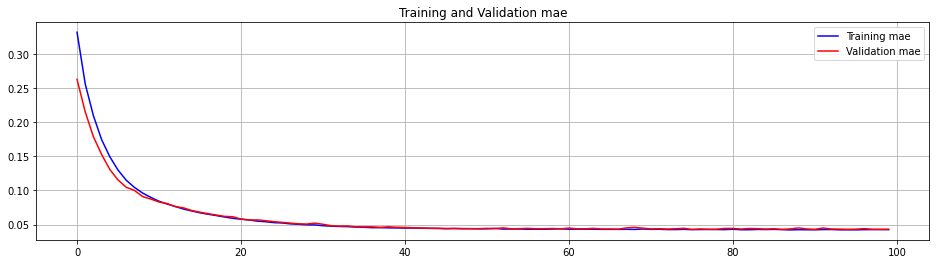

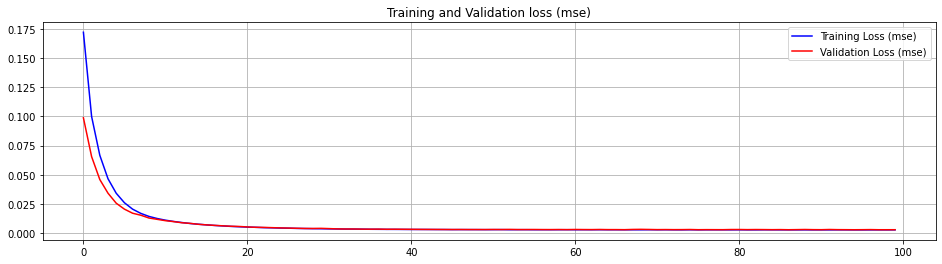

In [12]:
batch_size = 12
epochs = 100

# Definition of the settings
model_seq.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

# Training of the network
history = model_seq.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          verbose=0)

test_loss, test_mae = model_seq.evaluate(X_test, y_test)

print('Test loss (mse):', test_loss)
print('Test mean absolute error:', test_mae)
print_results()

**Here, we define the second model. Instead of one hidden layer with 10 neurons, we build two intermediate hidden fully conected layers of 6 and 4 neurons respectively and concatenate them**

In [13]:
tf.keras.backend.clear_session()
batch_size = 12
epochs = 100

inputs = tf.keras.Input(shape=(X_train.shape[1],))

split_1, split_2 = tf.split(inputs, 2, axis=1)
hidden_layer_1_1 = tf.keras.layers.Dense(6, activation="relu")(split_1)
hidden_layer_1_2 = tf.keras.layers.Dense(4, activation="relu")(split_2)

hidden_layer_1_output = tf.concat([hidden_layer_1_1, hidden_layer_1_2], axis=1)

outputs = tf.keras.layers.Dense(1)(hidden_layer_1_output)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 7),          0           ['input_1[0][0]']                
                                 (None, 7)]                                                       
                                                                                                  
 dense (Dense)                  (None, 6)            48          ['tf.split[0][0]']               
                                                                                                  
 dense_1 (Dense)                (None, 4)            32          ['tf.split[0][1]']           

**Again, we train the model with a batch size of 12 for 100 epochs**

5/5 [==============================] - 0s 4ms/step - loss: 0.0031 - mae: 0.0456
Test loss (mse): 0.0030708813574165106
Test mean absolute error: 0.04556412249803543


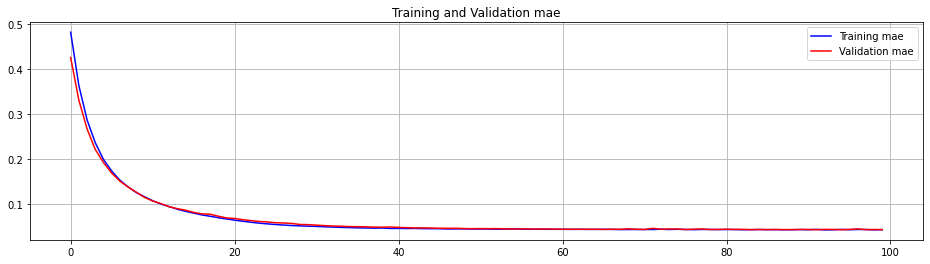

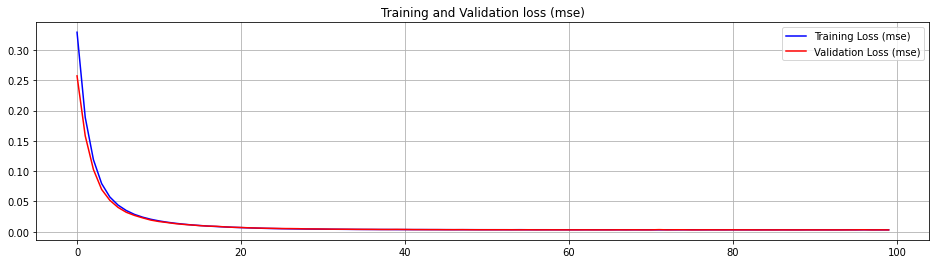

In [14]:
batch_size = 12
epochs = 100

# Definition of the settings
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

# Training of the network
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          verbose=0)

test_loss, test_mae = model.evaluate(X_test, y_test)

print('Test loss (mse):', test_loss)
print('Test mean absolute error:', test_mae)
print_results()

**The performance does look similar. It makes sense, since both models are indeed similar.**